In [2]:
import pandas as pd  
import plotly.express as px
import matplotlib.pyplot as plt

# Kaggle

In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
! chmod 600 ~/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
! kaggle datasets download saurabhshahane/fake-news-classification



Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [8]:
! unzip fake-news-classification.zip


unzip:  cannot find or open fake-news-classification.zip, fake-news-classification.zip.zip or fake-news-classification.zip.ZIP.


# Data loading & cleaning

In [3]:
df = pd.read_csv(r'/content/drive/MyDrive/DATASET/dataset.csv')

In [4]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [6]:
df['total_content'] = df['title']+ ' '+ df['text']

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string 
from nltk.tokenize import sent_tokenize, word_tokenize

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatization(content):
    lemmatized_content = re.sub('[^a-zA-Z]',' ',content)
    lemmatized_content = lemmatized_content.lower() 
    lemmatized_content = lemmatized_content.split() 
    lemmatized_content = [lemmatizer.lemmatize(word) for word in lemmatized_content if not word in stopwords.words('english')]
    lemmatized_content = ' '.join(lemmatized_content)
    return lemmatized_content

In [11]:
df['total_content'] = df['total_content'].apply(lemmatization)

In [12]:

import tensorflow as tf

import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns 

SEED = 10

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
X1 = df['total_content']
Y1 = df['label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, stratify = Y1, random_state = SEED)

In [19]:
tok = Tokenizer()
tok.fit_on_texts(X_train)

In [20]:
#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 169465


In [21]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq =keras.utils.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = keras.utils.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [23]:
X_train_seq.shape[1]


512

In [22]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 128)          21691520  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [26]:
history = model.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])


Epoch 1/10
671/671 [==============================] - 82s 122ms/step - loss: 0.0891 - accuracy: 0.9733 - val_loss: 0.1096 - val_accuracy: 0.9640
Epoch 2/10
671/671 [==============================] - 74s 111ms/step - loss: 0.0373 - accuracy: 0.9897 - val_loss: 0.1799 - val_accuracy: 0.9595
Epoch 3/10
671/671 [==============================] - 74s 110ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.1614 - val_accuracy: 0.9648
Epoch 4/10
671/671 [==============================] - 75s 111ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.1904 - val_accuracy: 0.9576
Epoch 5/10
671/671 [==============================] - 77s 115ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.1665 - val_accuracy: 0.9576
Epoch 6/10
671/671 [==============================] - 74s 110ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.2174 - val_accuracy: 0.9646


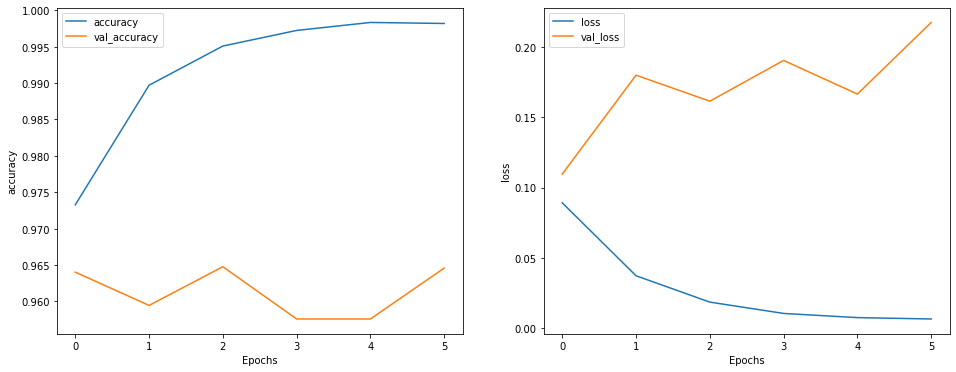

In [27]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [28]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 20s 34ms/step
Test Loss: 0.1558748036623001
Test Accuracy: 0.9649426937103271
